# Testing the reported peformance scores published for Electrohysterogram classification on the TPEHG dataset

In [189]:
from mlscorecheck.check.bundles.ehg import check_tpehg
from mlscorecheck.aggregated import kfolds_generator

Testing the scores reported in U. R. Acharya, V. K. Sudarshan, S. Q. Rong, Z. Tan, C. M. Lim, J. E. Koh,
S. Nayak, S. V. Bhandary, Automated detection of premature delivery using emipirical mode and wavelet packet decomposition techniques with uterine electromyogram signals, Computers in biology and medicine 85 (2017) 33–42. doi: 10.1016/j.compbiomed.2017.04.013

In [190]:
folds = list(kfolds_generator(evaluation={'dataset': {'p': 38, 'n': 262}, 'folding': {'n_folds': 5}},
                                available_scores=['acc', 'sens', 'spec']))

In [191]:
len(folds)

918

In [192]:
# the 5-fold cross-validation scores reported in the paper
scores = {'acc': 0.9447, 'sens': 0.9139, 'spec': 0.9733}
eps = 0.0001

In [193]:
results = check_tpehg(scores=scores, eps=eps, n_folds=5, n_repeats=1)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gykovacs/anaconda3/envs/mlscorecheck/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3b647ee87db24b6cae18e44cbd4abccc-pulp.mps RandomS 1 RandomC 1 randomS 1 randomC 1 timeMode elapsed branch printingOptions all solution /tmp/3b647ee87db24b6cae18e44cbd4abccc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 73 RHS
At line 80 BOUNDS
At line 92 ENDATA
Problem MODEL has 6 rows, 11 columns and 40 elements
Coin0008I MODEL read with 0 errors
randomSeed was changed from 1234567 to 1
randomCbcSeed was changed from -1 to 1
randomSeed was changed from 1 to 1
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0000I Cut generators found to be infeasible! (or unbounded)
Pre-processing says infeasible or unbounded
Option for printingOptions changed from normal to all
Total time (CPU seconds)

es
Problem is infeasible!
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gykovacs/anaconda3/envs/mlscorecheck/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/979f9b8535a14430b3d2935cc41fbe0f-pulp.mps RandomS 1 RandomC 1 randomS 1 randomC 1 timeMode elapsed branch printingOptions all solution /tmp/979f9b8535a14430b3d2935cc41fbe0f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 11 COLUMNS
At line 73 RHS
At line 80 BOUNDS
At line 92 ENDATA
Problem MODEL has 6 rows, 11 columns and 40 elements
Coin0008I MODEL read with 0 errors
randomSeed was changed from 1234567 to 1
randomCbcSeed was changed from -1 to 1
randomSeed was changed from 1 to 1
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.00 seconds
Cgl0003I 0 fixed, 6 tightened bou

In [194]:
results['inconsistency']

True

The results show that the scores are inconsistent with the setup, they could not be the outcome of the claimed evaluation.

## Testing the assumption of the improper use of minority oversampling

In [195]:
from mlscorecheck.aggregated import fold_partitioning_generator
from mlscorecheck.check.binary import check_1_dataset_known_folds_mos, check_1_dataset_unknown_folds_mos

In [196]:
# as reported in the paper
p_prime = 244
n = 262

In [197]:
# first we test with the high level functionality
results = check_1_dataset_unknown_folds_mos(dataset={'p': p_prime, 'n': n},
                                            folding={'n_folds': 5},
                                            scores=scores,
                                            eps=eps,
                                            verbosity=0)

In [198]:
results['inconsistency']

False

In [199]:
results['details'][-1]['configuration_id']

962

In [200]:
# counting the fold configurations

count = 0
for _ in fold_partitioning_generator(p=p_prime, n=n, k=5):
    count += 1

In [201]:
print(count)

2616607


In [202]:
# extracting the evidence
folds = []
tptn = []

evidence = results['details'][-1]['details']

for fold in evidence['lp_configuration']['evaluations'][0]['folds']['folds']:
    folds.append((fold['fold']['p'], fold['fold']['n']))
    tptn.append((fold['fold']['tp'], fold['fold']['tn']))

In [203]:
folds

[(1, 101), (4, 97), (40, 61), (99, 2), (100, 1)]

In [204]:
tptn

[(1.0, 96.0), (3.0, 92.0), (38.0, 59.0), (90.0, 2.0), (96.0, 1.0)]

## Power analysis

In [205]:
from sklearn.model_selection import KFold
import numpy as np

In [206]:
n_experiments = 100

In [207]:
38, 262

(38, 262)

In [208]:
y = np.hstack([np.repeat(0, 262), np.repeat(1, 262)])

In [214]:
n_experiments = 100
all_results = []
random_state = np.random.RandomState(5)

prop = 0.0

for k in [2, 3, 4]:
    print(k)
    for idx in range(n_experiments):
        #print('.', end='')

        tps = []
        tns = []
        lens = []
        ns = []
        ps = []
        for train, test in KFold(n_splits=5, shuffle=True, random_state=random_state).split(y.reshape(-1, 1), y):
            p = np.sum(y[test] == 1)
            n = np.sum(y[test] == 0)

            tps.append(int(random_state.randint(int((1 - prop)*p) + 1) + prop*p))
            tns.append(int(random_state.randint(int((1 - prop)*n) + 1) + prop*n))
            #tps.append(int(random_state.randint(p + 1)))
            #tns.append(int(random_state.randint(n + 1)))
            ns.append(n)
            ps.append(p)

        tps = np.array(tps)
        tns = np.array(tns)
        ns = np.array(ns)
        ps = np.array(ps)

        #print(tps, tns)

        acc = np.round(np.mean((tps + tns) / (ns + ps)), k)
        sens = np.round(np.mean((tps) / ps), k)
        spec = np.round(np.mean((tns) / ns), k)

        scores = {'acc': acc, 'sens': sens, 'spec': spec}
        results = check_tpehg(scores=scores, eps=10**(-k)/2, n_folds=5, n_repeats=1, verbosity=0, timeout=10)

        all_results.append((k, idx, results['inconsistency']))

        if results['inconsistency']:
            print('y', end='')
        else:
            print('n', end='')

2
ynynyynnnyynnnynynnnyynnnnnnnnnnnnnnyynnnnnnnnnnnnnyynynnyynnnnnnnyynnnynyynnnnnnnnnynnyynynnynynynn3
nnyynnnnnnynynnnnnyynyynynnnnynyyynnnyyynnnynynnynnynynnnyyynyynynnnnyynnnnyyynnynnyyyynnnnynnyynynn4
yyyyynnnyyyyyyyyyyyyynnnyynynynynyyynnynyyyynynynnyyyyynyyyynyynyyynynyynyynyyyynyyynynyynyyyynyyyyy

In [215]:

import pandas as pd

In [216]:
data = pd.DataFrame(all_results, columns=['k', 'idx', 'flag'])

In [243]:
results = data.groupby('k').agg({'flag': 'mean'})
results.index = [2, 3, 4]

In [244]:
import matplotlib.pyplot as plt

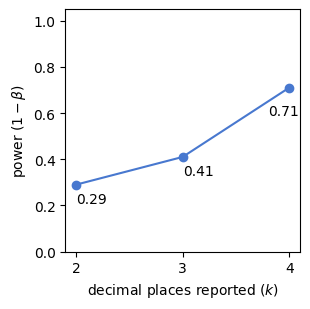

In [250]:
plt.figure(figsize=(3.2, 3.2))
plt.style.use('seaborn-v0_8-muted')
plt.plot(results.index, results['flag'])
plt.scatter(results.index, results['flag'])
ax = plt.gca()
#ax.set_xscale('log')
#ax.set_xticks(results.index, [r'${10^{-2}}/{2}$', r'${10^{-3}}/{2}$', r'${10^{-4}}/{2}$'])
ax.set_xticks([2, 3, 4], [2, 3, 4])
plt.ylim(0, 1.05)
plt.xlabel(r'decimal places reported ($k$)')
plt.ylabel(r'power ($1 - \beta$)')
#plt.grid(which='minor')
#plt.grid(which='major')
for i,j in zip(results.index[:2], results['flag'].iloc[:2]):
    ax.annotate(str(np.round(j, 2)),xy=(i,j), xytext=(i, j - 0.08))
ax.annotate(str(np.round(results['flag'].iloc[2], 2)), xy=(results.index[2], results['flag'].iloc[2]), xytext=(results.index[2]-0.2, results['flag'].iloc[2]-0.12))
plt.tight_layout()
plt.savefig('power-tpehg.eps')

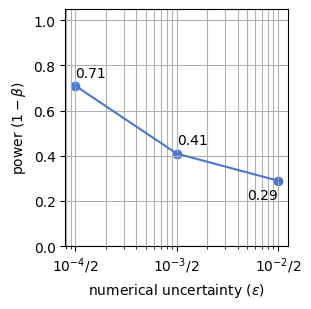

In [242]:
plt.figure(figsize=(3.2, 3.2))
plt.style.use('seaborn-v0_8-muted')
plt.plot(results.index, results['flag'])
plt.scatter(results.index, results['flag'])
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(results.index, [r'${10^{-2}}/{2}$', r'${10^{-3}}/{2}$', r'${10^{-4}}/{2}$'])
plt.ylim(0, 1.05)
plt.xlabel(r'numerical uncertainty ($\epsilon$)')
plt.ylabel(r'power ($1 - \beta$)')
plt.grid(which='minor')
plt.grid(which='major')
for i,j in zip(results.index[1:], results['flag'].iloc[1:]):
    ax.annotate(str(j),xy=(i,j), xytext=(i, j + 0.04))
ax.annotate(str(results['flag'].iloc[0]), xy=(results.index[0], results['flag'].iloc[0]), xytext=(results.index[0]-0.005, results['flag'].iloc[0]-0.08))
plt.tight_layout()
plt.savefig('power-tpehg.eps')